# The purpose of this notebook is to be a tool for plotting up WISPR images, making T-Maps of them, and integrating the inversion code to make tomograms

In [41]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import math

#import ImageCorrection.ImageCorrection as ImageCorrection
from scipy.signal import convolve as scipy_convolve
from astropy.io import fits
from astropy.time import Time, TimeDelta

import copy

import os

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import operator

from skimage import data
from skimage.filters import unsharp_mask

import re

# As long as the desired data set is downloaded on my machine (and in the right place), I should be able to retrieve it and process it to make a T-Map

In [97]:
WISPR_folder_path = '/Users/mkenny/Documents/PSP/WISPR_Data/'
perihelion_number = input("Which perihelion?  ")

Which perihelion?  7


In [98]:
if int(perihelion_number) < 10:
    perihelion_number = str(0) + perihelion_number

In [99]:
perihelion_folder_path = WISPR_folder_path + 'orbit' + perihelion_number 
os.listdir(perihelion_folder_path)


['P7_20210117_655_1617802725 ',
 '.DS_Store',
 'P7_20210118_655_1617992810',
 'P7_20210116_655_1617992757']

In [100]:
selected_observation = input("Copy and paste the data set you'd like to analyze: ")

Copy and paste the data set you'd like to analyze: P7_20210118_655_1617992810


In [101]:
selected_observation_path = perihelion_folder_path + '/' + selected_observation
selected_data = os.listdir(selected_observation_path)
number_of_images_in_observation = len(selected_data)

# Initialize image cubes to fill once sorted

combined_cube = []
inner_camera_cube = []; outer_camera_cube = []
inner_camera_count = 0;  outer_camera_count = 0
date_time_info = []


# First for loop finds given ordering of fits files, which we will sort in time

for i in range(number_of_images_in_observation):
    fits_file = selected_data[i]
    file_path = selected_observation_path + "/" +  fits_file
    hdu_list = fits.open( file_path )
    hdr = hdu_list[0].header
    
    date_time_info.append(hdr['DATE-OBS'])

    
# Sort fits by time

date_time_list = Time(date_time_info, format = 'fits')

time_sorted_indices = Time.argsort(date_time_list)
sorted_date_time_list = date_time_list[time_sorted_indices]
date_time_list = sorted_date_time_list

#print(date_time_list)
# Initialize list of sorted fits files (i.e. images)

sorted_fits_files = []

for index in time_sorted_indices:
    file_path = selected_observation_path + "/" + selected_data[index] #for index in indices_sorted_date_and_time]
    hdu_list = fits.open(file_path) 
    header = hdu_list[0].header
    data = hdu_list[0].data
    sorted_fits_files.append(data)
    if header['DETECTOR'] == 1:
        inner_camera_count += 1
        inner_camera_cube.append(data)
    elif header['DETECTOR'] == 2:
        outer_camera_count += 1
        outer_camera_cube.append(data) 

    
hdu_combined = fits.PrimaryHDU(np.array(sorted_fits_files))
hdu_inner = fits.PrimaryHDU(np.array(inner_camera_cube))
hdu_outer = fits.PrimaryHDU(np.array(outer_camera_cube))

first_date_time = str(date_time_list[0])
date_and_time = first_date_time[0:first_date_time.find('T')]


if not os.path.exists('WISPR_Fits/orbit' + perihelion_number + '/'):
    os.makedirs('WISPR_Fits/orbit' + perihelion_number + '/')

hdu_inner.writeto('WISPR_Fits/orbit' + perihelion_number + '/' + date_and_time + '_L2_inner_FOV_cube_sorted.fits', overwrite=True)
hdu_outer.writeto('WISPR_Fits/orbit' + perihelion_number + '/' + date_and_time + '_L2_outer_FOV_cube_sorted.fits', overwrite=True)
hdu_combined.writeto('WISPR_Fits/orbit' + perihelion_number + '/' + date_and_time + '_L2_combined_FOV_cube_sorted.fits', overwrite=True)



In [102]:
inner_cube_path = 'WISPR_Fits/orbit' + perihelion_number + '/' + date_and_time + '_L2_inner_FOV_cube_sorted.fits'
outer_cube_path = 'WISPR_Fits/orbit' + perihelion_number + '/' + date_and_time + '_L2_outer_FOV_cube_sorted.fits'
combined_cube_path = 'WISPR_Fits/orbit' + perihelion_number + '/' + date_and_time + '_L2_combined_FOV_cube_sorted.fits'

inner_hdu_list = fits.open(inner_cube_path) ; outer_hdu_list = fits.open(outer_cube_path)
inner_cube_data = inner_hdu_list[0].data ; outer_cube_data = outer_hdu_list[0].data 
inner_cube = copy.copy(inner_cube_data) ; outer_cube = copy.copy(outer_cube_data)


FOV_selection = input("Do you want to analyze inner or outer FOV images? For inner, type '1'; for outer, type '2':  ")

Do you want to analyze inner or outer FOV images? For inner, type '1'; for outer, type '2':  2


In [103]:
if FOV_selection == '1':
    cube = inner_cube
    num_images = inner_camera_count
    plot_title_word = 'Inner'
elif FOV_selection == '2':
    cube = outer_cube
    num_images = outer_camera_count
    plot_title_word = 'Outer'
else: 
    FOV_selection = input("Do you want to analyze inner or outer FOV images? For inner, type '1'; for outer, type '2':  ")

# Process the inner and outer data cubes: remove NaNs, median over central 60 columns of data, re-scale values, and median-subtract by columns and by rows (separately)

In [119]:
# Nullify NaNs 
cube[ np.isnan( cube ) ] = 0 

# Median central 60 columns
cube_cols_to_median = cube[:,:,445:505] # central 60 columns
med_central_60_cols = np.median(cube_cols_to_median, axis=2)
TMap_image = np.transpose(med_central_60_cols, (1,0)) # turn it sideways!

## Rescale values to remove negative numbers
TopValue = 100 # arbitrary upper limit 
TMap_image = TopValue*(TMap_image - np.min(TMap_image))/np.max(TMap_image)
Tmap = TMap_image

# Specify columns and rows of the image 
col_medians = np.median(Tmap, axis=0)
row_medians = np.median(Tmap, axis=1)

In [120]:
num_time_steps = num_images
height = cube[1]
print(np.min(Tmap),np.max(Tmap))

for column_index in range(num_time_steps):
    Tmap[:,column_index] = Tmap[:,column_index] - col_medians[column_index]


for row_index in range(len(height)):
    Tmap[row_index,:] = Tmap[row_index,:] - row_medians[row_index]
    
print(np.min(Tmap),np.max(Tmap))
aspect_ratio = num_time_steps / 1024

0.0 100.0
-69.42211023476577 -49.62598053764921


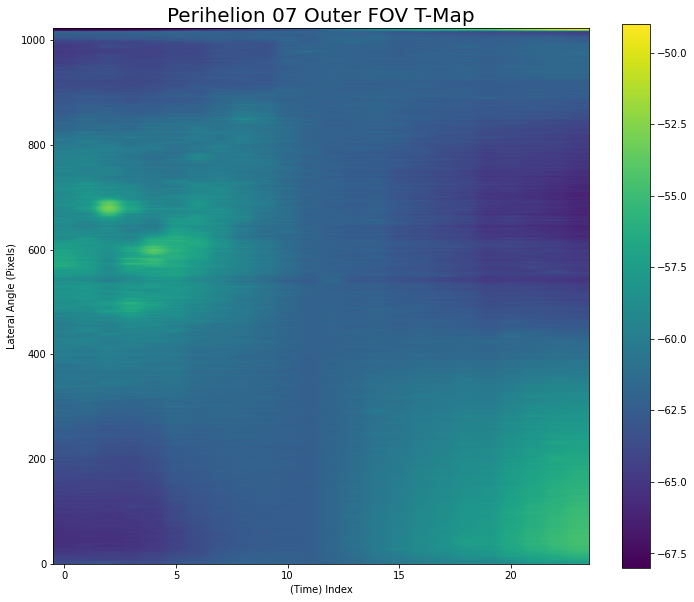

In [121]:
plt.figure(figsize=(12,10))
plt.imshow(Tmap, aspect=aspect_ratio, origin='lower',vmin= -68,vmax=-49,cmap='viridis')
plt.ylabel('Lateral Angle (Pixels)'), plt.xlabel('(Time) Index')
plt.title('Perihelion ' + perihelion_number + ' ' + plot_title_word + ' FOV T-Map',fontsize=20)
plt.colorbar()


## Next steps:

#### Make uniform time steps
#### Apply median filtering and other image processing tricks to improve images
#### Inversion?